# First, import data

In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# Get images with segmentation

which_slice = 15
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1 = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2 = f(tif)

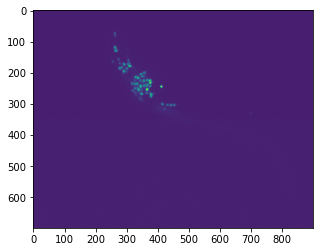

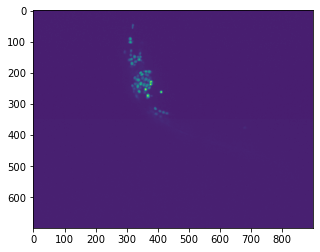

In [3]:
plt.imshow(im1)
plt.figure()
plt.imshow(im2)

In [4]:
im1.shape

(700, 900)

## Get segmentation and matching points

In [5]:
from DLC_for_WBFM.utils.point_clouds.utils_bcpd_segmentation import bcpd_to_pixels, pixels_to_bcpd
import cv2
import open3d as o3d


In [67]:
# First, extract features and match
# MAX_FEATURES = 10000
# GOOD_MATCH_PERCENT = 0.20

def convert_to_grayscale(im1):
    try:
        im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    except:
        im1Gray = im1
    
    return im1Gray


def detect_features_and_match(im1, im2, 
                              MAX_FEATURES=3000,
                              matches_to_keep=0.2):
    
    im1Gray = convert_to_grayscale(im1)
    im2Gray = convert_to_grayscale(im2)
    
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * matches_to_keep)
    matches = matches[:numGoodMatches]
    
    return keypoints1, keypoints2, matches


def match_using_known_keypoints(im1, kp1, im2, kp2, MAX_FEATURES=1000, use_flann=False):

    # Match features.
    if use_flann:
        
        # Initiate SIFT detector
        sift = cv2.SIFT()

        # find the keypoints and descriptors with SIFT
        _, descriptors1 = sift.compute(im1,kp1)
        _, descriptors2 = sift.compute(im2,kp2)
        # FLANN parameters
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary

        flann = cv2.FlannBasedMatcher(index_params,search_params)

        matches = flann.knnMatch(descriptors1,descriptors2,k=1)
        
    else:
        orb = cv2.ORB_create(MAX_FEATURES)
        _, descriptors1 = orb.compute(im1, kp1)
        _, descriptors2 = orb.compute(im2, kp2)
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    #     matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_FLANNBASED)
        matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
#     numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
#     matches = matches[:numGoodMatches]
    
    return kp1, kp2, matches

In [73]:
def extract_location_of_matches(matches, keypoints1, keypoints2):
    
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    return points1, points2


def build_neuron_tree(neurons):
    """
    Build neuron point cloud
    """
    pc = o3d.geometry.PointCloud()

    num_neurons = neurons.shape[0]
    # the segmentations are mirrored
    flip = lambda n : np.array([n[0], n[2], n[1]])
    neurons = np.array([flip(row) for row in neurons])

    # Build point cloud and tree
    pc.points = o3d.utility.Vector3dVector(neurons)
    pc_tree = o3d.geometry.KDTreeFlann(pc)

    return num_neurons, pc, pc_tree


def build_feature_tree(features):
    """
    Build feature point cloud
    """
    pc = o3d.geometry.PointCloud()
    
    num_features = features.shape[0]

    # Add 3rd dimension to the features
    if len(features[0])==2:
        features_3d = np.array([np.hstack((which_slice, row)) for row in features])
    else:
        features_3d = features

    # Build point cloud and tree
    pc.points = o3d.utility.Vector3dVector(features_3d)
    pc_tree = o3d.geometry.KDTreeFlann(pc)

    return num_features, pc, pc_tree


def match_centroids_using_tree(neurons0, 
                               neurons1, 
                               features0, 
                               features1,
                               radius=1,
                               max_nn=10,
                               min_features_needed=1,
                               verbose=0):
    """
    Uses a combined point cloud (neurons and features) to do the following:
    1. Assign features, f0, in vol0 to neurons in vol0, n0
    2. Match features f0 to features in vol1, f1
    3. Find the single neuron in vol1, n1, matching most of the features, f1
    """
    
    # Build point clouds and trees
    num_features0, pc_f0, tree_features0 = build_feature_tree(features0)
    num_features1, pc_f1, tree_features1 = build_feature_tree(features1)
    num_neurons0, pc_n0, _ = build_neuron_tree(neurons0)
    num_neurons1, pc_n1, tree_neurons1 = build_neuron_tree(neurons1)

    # First, build dictionary to translate features to neurons
    features_to_neurons1 = np.zeros(len(features1))
    for i in range(num_features1):
        # Get features of this neuron and save
#         this_feature = np.hstack((which_slice, this_feature))
        this_feature = np.asarray(pc_f1.points)[i]
        [k, this_fn1, _] = tree_neurons1.search_hybrid_vector_3d(this_feature, radius=5*radius, max_nn=1)

        if k>0:
            features_to_neurons1[i] = this_fn1[0]
            
        if verbose >= 4:
            pc_f0.paint_uniform_color([0.5, 0.5, 0.5])

            one_point = o3d.geometry.PointCloud()
            one_point.points = o3d.utility.Vector3dVector([this_feature])
            one_point.paint_uniform_color([1,0,0])
    
            np.asarray(pc_f0.colors)[this_f0[1:], :] = [0, 1, 0]

#             print("Visualize the point cloud.")
            o3d.visualization.draw_geometries([one_point,pc_f0])
    
    # Second, loop through neurons of first frame
    from scipy import stats
    all_matches = []
    for i in range(neurons0.shape[0]):
        # Get features of this neuron
        this_neuron = np.asarray(pc_n0.points)[i]
        [_, this_f0, _] = tree_features0.search_hybrid_vector_3d(this_neuron, radius=radius, max_nn=max_nn)
        
        if verbose >= 3:
            pc_f0.paint_uniform_color([0.5, 0.5, 0.5])

            one_point = o3d.geometry.PointCloud()
            one_point.points = o3d.utility.Vector3dVector([this_neuron])
            one_point.paint_uniform_color([1,0,0])
    
            np.asarray(pc_f0.colors)[this_f0[1:], :] = [0, 1, 0]

#             print("Visualize the point cloud.")
            o3d.visualization.draw_geometries([one_point,pc_f0])
        
        # Get the corresponding neurons in vol1, and vote
        this_n1 = features_to_neurons1[this_f0]
        if len(this_n1) >= min_features_needed:
            all_matches.append([i, int(stats.mode(this_n1)[0][0])])
            if verbose >= 1:
                print(f"Matched neuron {i} based on {len(this_f0)} features")
        else:
            all_matches.append([i, 0]) # TODO
            if verbose >= 1:
                print(f"Could not match neuron {i}")
    
    return all_matches, features_to_neurons1


def visualize_tracks(neurons0, neurons1, matches, to_plot_failed_lines=False):
    n0, pc_n0, tree_neurons0 = build_neuron_tree(neurons0)
    n1, pc_n1, tree_neurons1 = build_neuron_tree(neurons1)
    pc_n0.paint_uniform_color([0.5,0.5,0.5])
    pc_n1.paint_uniform_color([0,0,0])

    # Plot lines from initial neuron to target
    points = np.vstack((pc_n0.points,pc_n1.points))

    tmp = list(matches)
    for i,match in enumerate(matches):
        tmp[i][1] = (n0 + match[1])

    successful_lines = []
    failed_lines = []
    for row in tmp:
        if row[1] != n0:
            successful_lines.append(row)
        else:
            failed_lines.append(row)

    successful_colors = [[0, 1, 0] for i in range(len(successful_lines))]
    successful_line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(successful_lines),
    )
    successful_line_set.colors = o3d.utility.Vector3dVector(successful_colors)
    if to_plot_failed_lines:
        failed_colors = [[1, 0, 0] for i in range(len(failed_lines))]
        failed_line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(points),
            lines=o3d.utility.Vector2iVector(failed_lines),
        )
        failed_line_set.colors = o3d.utility.Vector3dVector(failed_colors)
        o3d.visualization.draw_geometries([failed_line_set, successful_line_set, pc_n0, pc_n1])
    else:
        o3d.visualization.draw_geometries([successful_line_set, pc_n0, pc_n1])

In [8]:
im1.shape

(700, 900)

In [9]:
keypoints0, keypoints1, matches = detect_features_and_match(im1, im2)

features0, features1 = extract_location_of_matches(matches, keypoints0, keypoints1)

In [10]:
# Second, assign features to segmented neurons and match neurons

# Load segmentation centroids
seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
seg_vol0 = np.loadtxt(seg_fname0)
# TODO: text files are saved in a reduced location space
neurons0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
seg_vol1 = np.loadtxt(seg_fname1)
neurons1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

In [12]:
dat,_=match_centroids_using_tree(neurons0, 
                               neurons1, 
                               features0, 
                               features1,
                               radius=5,
                               max_nn=20)

In [13]:
n0, pc_n0, tree_neurons0 = build_neuron_tree(neurons0)
n1, pc_n1, tree_neurons1 = build_neuron_tree(neurons1)
pc_n0.paint_uniform_color([0.5,0.5,0.5])
pc_n1.paint_uniform_color([0,0,0])

# Plot lines from initial neuron to target
points = np.vstack((pc_n0.points,pc_n1.points))

tmp = dat.copy()
for i,match in enumerate(dat):
    tmp[i][1] = (n0 + match[1])#.astype('uint32')

successful_lines = []
failed_lines = []
for row in tmp:
    if row[1] != n0:
        successful_lines.append(row)
    else:
        failed_lines.append(row)

In [14]:
successful_colors = [[0, 1, 0] for i in range(len(successful_lines))]
successful_line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(successful_lines),
)
failed_colors = [[1, 0, 0] for i in range(len(failed_lines))]
failed_line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(failed_lines),
)
failed_line_set.colors = o3d.utility.Vector3dVector(failed_colors)
successful_line_set.colors = o3d.utility.Vector3dVector(successful_colors)
o3d.visualization.draw_geometries([failed_line_set, successful_line_set, pc_n0, pc_n1])

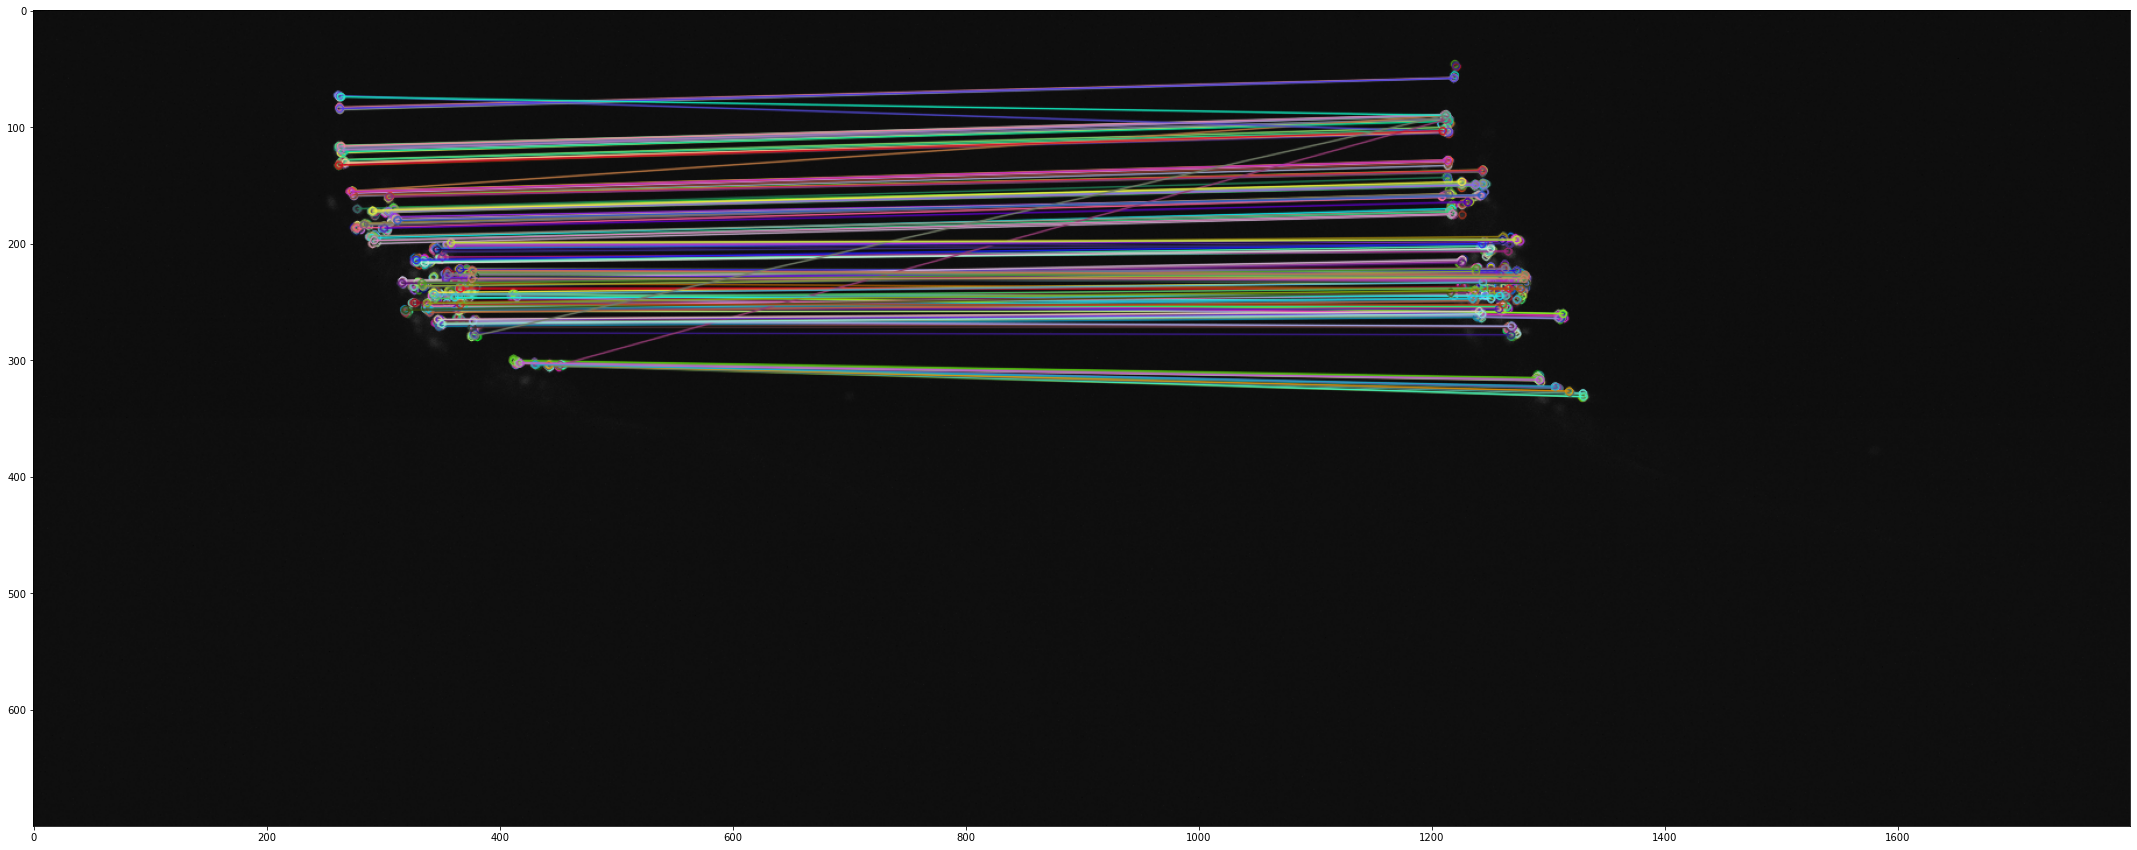

In [28]:

imMatches = cv2.drawMatches(im1, keypoints0, im2, keypoints1, matches, None)
fig, axis = plt.subplots(figsize=(45, 15))

plt.imshow(imMatches)

## Full: build features on all planes

In [49]:
# Get images with segmentation

alpha = 0.15
dat_foldername = r'..\point_cloud_alignment'

def build_features_on_all_planes(fname0, fname1, verbose=1, start_plane=10,
                                detect_keypoints=True,
                                kp0=None,
                                kp1=None,
                                sz=31.0):

    f = lambda tif : (alpha*tif.asarray()).astype('uint8')

    vol0 = os.path.join(dat_foldername, fname0)
    vol1 = os.path.join(dat_foldername, fname1)
    with tifffile.TiffFile(vol0) as tif0:
        dat0 = f(tif0)
    with tifffile.TiffFile(vol1) as tif1:
        dat1 = f(tif1)
            
    all_features0 = []
    all_features1 = []
    for i in range(dat0.shape[0]):
        if i<start_plane:
            continue
        im0 = np.squeeze(dat0[i,...])
        im1 = np.squeeze(dat1[i,...])
        if detect_keypoints:
            keypoints0, keypoints1, matches = detect_features_and_match(im0, im1, 10000, 0.5)
        else:
            kp0_cv2 = get_keypoints_from_3dseg(kp0, i, sz=sz)
            kp1_cv2 = get_keypoints_from_3dseg(kp1, i, sz=sz)
            keypoints0, keypoints1, matches = match_using_known_keypoints(im0, kp0_cv2, im1, kp1_cv2, 1000)
        features0, features1 = extract_location_of_matches(matches, keypoints0, keypoints1)
        
        if verbose >= 3:
            imMatches = cv2.drawMatches(im0, keypoints0, im1, keypoints1, matches, None)
            fig, axis = plt.subplots(figsize=(45, 15))
            plt.imshow(imMatches)
        
        if verbose >= 2:
            print(f"Adding {len(features0)} features from plane {i}")
#             print(f"Adding {len(features1)} features from plane {i} in volume 1")
        features_3d = np.array([np.hstack((i, row)) for row in features0])
        all_features0.extend(features_3d)
        features_3d = np.array([np.hstack((i, row)) for row in features1])
        all_features1.extend(features_3d)
    
    return np.array(all_features0), np.array(all_features1), keypoints0, keypoints1


def get_keypoints_from_3dseg(kp0, i, sz=31.0):
    kp_cv2 = []
    for z,x,y in kp0:
        if abs(z-i) < 3.0:
            kp_cv2.append(cv2.KeyPoint(y,x,sz))
    
    return kp_cv2

In [76]:
# Second, assign features to segmented neurons and match neurons

# Load segmentation centroids
seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
seg_vol0 = np.loadtxt(seg_fname0)
# TODO: text files are saved in a reduced location space
neurons0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
seg_vol1 = np.loadtxt(seg_fname1)
neurons1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

all_features0, all_features1, kp0, kp1 = build_features_on_all_planes('img100.tif','img101.tif',verbose=1, 
                                                            detect_keypoints=True,
                                                            kp0=neurons0,
                                                            kp1=neurons1)

In [77]:
dat, f2n=match_centroids_using_tree(neurons0, 
                               neurons1, 
                               all_features0, 
                               all_features1,
                               radius=5,
                               max_nn=50,
                               min_features_needed=1,
                                   verbose=1)

Could not match neuron 0
Matched neuron 1 based on 1 features
Matched neuron 2 based on 33 features
Matched neuron 3 based on 17 features
Matched neuron 4 based on 32 features
Matched neuron 5 based on 19 features
Matched neuron 6 based on 37 features
Matched neuron 7 based on 12 features
Matched neuron 8 based on 15 features
Matched neuron 9 based on 3 features
Matched neuron 10 based on 39 features
Matched neuron 11 based on 31 features
Matched neuron 12 based on 5 features
Matched neuron 13 based on 24 features
Matched neuron 14 based on 9 features
Matched neuron 15 based on 27 features
Matched neuron 16 based on 11 features
Matched neuron 17 based on 16 features
Matched neuron 18 based on 7 features
Could not match neuron 19
Matched neuron 20 based on 9 features
Matched neuron 21 based on 8 features
Matched neuron 22 based on 3 features
Matched neuron 23 based on 1 features
Matched neuron 24 based on 2 features
Matched neuron 25 based on 30 features
Matched neuron 26 based on 47 fe

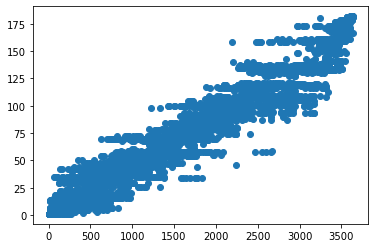

In [78]:
plt.plot(f2n, 'o')

In [79]:
visualize_tracks(neurons0, neurons1, dat, to_plot_failed_lines=False)

## Tests

In [14]:
radius = 5
max_nn = 30

# Build point clouds
n0, pc_f0, tree_features0 = build_feature_tree(features0)
n1, pc_n1, tree_neurons1 = build_neuron_tree(neurons1)

n_total1 = np.asarray(pc1.points).shape[0]

# First, build dictionary to translate features to neurons
features_to_neurons1 = np.zeros(len(features1))
for i, this_feature in enumerate(features1):
    # Get features of this neuron and save
#     this_feature = pc1.points[i]
    this_feature = np.hstack((which_slice, this_feature))
    [k, this_fn1, _] = tree_neurons1.search_hybrid_vector_3d(this_feature, radius=10, max_nn=1)
#     print(this_fn1)

    if k>0:
        features_to_neurons1[i] = this_fn1[0]

    # Find the closest thing that is a neuron
    
#     for fn in this_fn1:
#         if fn < n1:
# #             print(fn)
#             features_to_neurons1[i] = fn
#             break
#     else:
#         print(f"Found no match for feature {i}")
    
# print("Features correpond to the following neurons: ",features_to_neurons1)

NameError: name 'o3d' is not defined

In [224]:
# clouds
n0, pc_n0, _ = build_neuron_tree(neurons0)
n1, pc_f1, _ = build_feature_tree(features1)


pc_f0.paint_uniform_color([0.5, 0.5, 0.5])
pc_f1.paint_uniform_color([0.5, 0.5, 0.5])
# o3d.visualization.draw_geometries([pc_f0, pc_n0])
o3d.visualization.draw_geometries([pc_f1, pc_n1])

In [283]:
# Second, loop through neurons of first frame
from scipy import stats
all_matches = []
for i in range(n0):
    # Get features of this neuron
    this_neuron = np.asarray(pc_n0.points)[i]
    [k, this_f0, _] = tree_features0.search_hybrid_vector_3d(this_neuron, radius=10, max_nn=max_nn)
#     [k, this_f0, dist] = tree_features0.search_knn_vector_3d(this_neuron, knn=1)

#     print("Closest neighbor location",np.asarray(pc_f0.points)[this_f0])
#     print("Neuron location:", this_neuron)
#     print("Closest point in neuron point cloud ", np.asarray(pc_n0.points)[i])
#     print("Distance", dist)
    
    # Get locations of matches in other set of features
    # Note: the indices in features0 and features1 are already aligned
#     this_f1 = features1[this_f0,:]

    # Get the corresponding neurons in vol1, and vote
    this_n1 = features_to_neurons1[this_f0]
    all_matches.append(stats.mode(this_n1)[0])
#     print("Found best match", all_matches[i])
all_matches

[array([], dtype=float64),
 array([29.]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([5.]),
 array([36.]),
 array([6.]),
 array([37.]),
 array([20.]),
 array([39.]),
 array([11.]),
 array([14.]),
 array([15.]),
 array([16.]),
 array([17.]),
 array([18.]),
 array([19.]),
 array([22.]),
 array([22.]),
 array([], dtype=float64),
 array([10.]),
 array([39.]),
 array([32.]),
 array([32.]),
 array([], dtype=float64),
 array([35.]),
 array([14.]),
 array([12.]),
 array([29.]),
 array([20.]),
 array([48.]),
 array([40.]),
 array([31.]),
 array([42.]),
 array([33.]),
 array([41.]),
 array([34.]),
 array([36.]),
 array([18.]),
 array([44.]),
 array([40.]),
 array([40.]),
 array([39.]),
 array([16.]),
 array([], dtype=float64),
 array([47.]),
 array([48.]),
 array([38.]),
 array([33.]),
 array([33.]),
 array([41.]),
 array([], dtype=float64),
 array([20.]),
 array([48.]),
 array([], dtype=float64),
 array([54.]),
 array([], dtype=float64),
 array([35.]),
 array([], dtype=float64

## nearest neighbors example

In [13]:
# From: http://www.open3d.org/docs/latest/tutorial/Basic/kdtree.html
import open3d as o3d
from DLC_for_WBFM.utils.point_clouds.utils_bcpd import prepare_source_and_target_nonrigid_3d

print("Testing kdtree in Open3D...")
print("Load a point cloud and paint it gray.")

source, target = prepare_source_and_target_nonrigid_3d(seg_fname0, seg_fname1, None)

Testing kdtree in Open3D...
Load a point cloud and paint it gray.
PointCloud with 187 points.
PointCloud with 185 points.


In [40]:
# pcd = o3d.io.read_point_cloud(seg_fname, format='pcd')
source.paint_uniform_color([0.5, 0.5, 0.5])
pcd_tree = o3d.geometry.KDTreeFlann(source)

print("Paint the 50th point red.")
source.colors[50] = [1, 0, 0]


print("Find its neighbors with distance less than 5, and paint them green.")
[k, idx, _] = pcd_tree.search_radius_vector_3d(source.points[50], 0.5)
np.asarray(source.colors)[idx[1:], :] = [0, 1, 0]


print("Find its 10 nearest neighbors, and paint them blue.")
[k, idx, _] = pcd_tree.search_knn_vector_3d(source.points[50], 10)
np.asarray(source.colors)[idx[1:], :] = [0, 0, 1]

print("Visualize the point cloud.")
o3d.visualization.draw_geometries([source])

Paint the 50th point red.
Find its neighbors with distance less than 5, and paint them green.
Find its 10 nearest neighbors, and paint them blue.
Visualize the point cloud.


## Example 2: build a neuron + features point cloud

In [15]:
# From: http://www.open3d.org/docs/latest/tutorial/Basic/kdtree.html
import open3d as o3d
from DLC_for_WBFM.utils.point_clouds.utils_bcpd import prepare_source_and_target_nonrigid_3d

# Get segmented neurons
# seg_fname0 = os.path.join(dat_foldername, 'test_vol0.txt')
# seg_vol0 = np.loadtxt(seg_fname)
# # TODO: text files are saved in a reduced location space
# seg_vol0 = np.array([bcpd_to_pixels(row) for row in seg_vol0])

# seg_fname1 = os.path.join(dat_foldername, 'test_vol1.txt')
# seg_vol1 = np.loadtxt(seg_fname)
# seg_vol1 = np.array([bcpd_to_pixels(row) for row in seg_vol1])

# Get features
keypoints0, keypoints1, matches = detect_features_and_match(im1, im2)
loc0, loc1 = extract_location_of_matches(matches, keypoints0, keypoints1)

In [19]:
# Build combined point cloud
pc = o3d.geometry.PointCloud()

num_neurons0 = seg_vol0.shape[0]

# the segmentations are mirrored
flip = lambda seg : np.array([seg[0], seg[2], seg[1]])
# flip = lambda x : x
neurons = np.array([flip(row) for row in seg_vol0])

# Add 3rd dimension to the features
loc0_3d = np.array([np.hstack((which_slice, row)) for row in loc0])

pc.points = o3d.utility.Vector3dVector(np.vstack((neurons, loc0_3d)))

In [20]:
pc.paint_uniform_color([0.5, 0.5, 0.5])

print("Keep the features gray.")
print("Paint the neurons green.")
# [k, idx, _] = pcd_tree.search_radius_vector_3d(source.points[50], 0.5)
idx = range(num_neurons0)
np.asarray(pc.colors)[idx, :] = [0, 1, 0]

# [k, idx, _] = pcd_tree.search_radius_vector_3d(source.points[50], 0.5)
# np.asarray(source.colors)[idx[1:], :] = [0, 1, 0]

Keep the features gray.
Paint the neurons green.


In [21]:
xyz = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[0, 0, 0])
xyz2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[0, 100, 100])
xyz3 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[0, 200, 200])

o3d.visualization.draw_geometries([pc, xyz, xyz2, xyz3])

# Old: direct alignment

In [25]:
# FROM LUKAS
# The whole filter procedure as function:
# The image has to be square
# Option for the future: add pixel on the smaller side to make it square and crop after filtering
def filterImage(filterImg, highFrequ, lowFrequ):
    (x, y) = filterImg.shape
    if x != y:
        print('Error: Image is not quadratic!')
        return -1
    # set filter values
    rhigh = highFrequ # how narrower the window is
    rlow = lowFrequ
    ham = np.hamming(x)[:,None] # 1D hamming
    ham2dhigh = np.sqrt(np.dot(ham, ham.T)) ** rhigh # expand to 2D hamming
    ham2dlow = np.sqrt(np.dot(ham, ham.T)) ** rlow
    ham2d = ham2dhigh - ham2dlow
    # check if image is square
    # calculate fourier transform
    f = cv2.dft(filterImg.astype('float32'), flags=cv2.DFT_COMPLEX_OUTPUT)
    # reorder result quarters
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    # apply filter mask
    f_filtered = ham2d * f_complex
    # reorder result
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    return filtered_img

# Try 1: Use ECC for alignment

Following:
https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

In [26]:
import cv2
import matplotlib.pyplot as plt
import timeit

In [27]:
# From: https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

# Convert images to grayscale
# im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
# im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

im1_gray = im1.astype('float32')
im2_gray = im2.astype('float32')

# Find size of image1
sz = im1.shape

# Define the motion model
# warp_mode = cv2.MOTION_EUCLIDEAN
warp_mode = cv2.MOTION_AFFINE

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 5000;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

In [28]:
start = timeit.timeit()

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

end = timeit.timeit()
print("Time elapsed: ", end - start)

Time elapsed:  -0.0022641579994342464


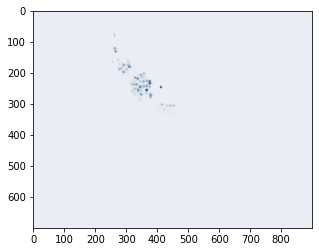

In [29]:
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

# Show final results
fig, axis = plt.subplots(figsize=(5, 5))
axis.imshow(im1, cmap='Reds', alpha=0.8)
axis.imshow(im2_aligned, cmap='Blues', alpha=0.8)
# plt.figure(figsize=(25,25))
# plt.subplot(131)
# plt.imshow(im1)
# plt.subplot(132)
# plt.imshow(im2)
# plt.subplot(133)
# plt.imshow(im2_aligned)
# cv2.waitKey(0)

# Try 2: Feature-based alignment

Following:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

In [54]:
import cv2
import numpy as np
import timeit
from skimage import transform
import matplotlib.pyplot as plt

In [55]:
MAX_FEATURES = 3000
GOOD_MATCH_PERCENT = 0.40

In [39]:
# def convert_to_grayscale(im1, im2):
#     try:
#         im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
#         im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
#     except:
#         im1Gray = im1
#         im2Gray = im2
    
#     return im1Gray, im2Gray


# def detect_features_and_match(im1, im1Gray, im2, im2Gray):
    
#     orb = cv2.ORB_create(MAX_FEATURES)
#     keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
#     keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

#     # Match features.
#     matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#     matches = matcher.match(descriptors1, descriptors2, None)

#     # Sort matches by score
#     matches.sort(key=lambda x: x.distance, reverse=False)

#     # Remove not so good matches
#     numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
#     matches = matches[:numGoodMatches]
    
#     return keypoints1, keypoints2, matches




# def extract_location_of_matches(matches, keypoints1, keypoints2):
    
#     points1 = np.zeros((len(matches), 2), dtype=np.float32)
#     points2 = np.zeros((len(matches), 2), dtype=np.float32)

#     for i, match in enumerate(matches):
#         points1[i, :] = keypoints1[match.queryIdx].pt
#         points2[i, :] = keypoints2[match.trainIdx].pt
    
#     return points1, points2

In [57]:
def alignImages(im1, im2, use_skimage=True):
    """
    Aligns two images using orb-generated features
    
    Args:
        im1: numpy image in XY or XYC (color optional)
        
        im2: same format as im1
    """
    
    # Convert images to grayscale
    im1Gray, im2Gray = convert_to_grayscale(im1, im2)

    # Features
    keypoints1, keypoints2, matches = detect_features_and_match(im1, im1Gray, im2, im2Gray)

    # Extract location of good matches
    points1, points2 = extract_location_of_matches(matches, keypoints1, keypoints2)

    # Find homography
#     h, mask = cv2.estimateAffine2D(points1, points2)
    if use_skimage:
        h = transform.estimate_transform('euclidean', points1, points2)
    else:
        h, mask = cv2.estimateAffinePartial2D(points1, points2)

    # Use homography
    # Only width and height, removing color channels if any
    if use_skimage:
        im1Reg = transform.warp(im1, inverse_map=h.inverse) 
#         im1Reg = None
    else:
        im1Reg = cv2.warpAffine(im1, h, im2.shape[:2])

    return im1Reg, h, keypoints1, keypoints2, matches

# Compare feature-based algorithms

In [58]:
start = timeit.timeit()

im1Reg_cv2, h, keypoints1, keypoints2, matches = alignImages(im1, im2, False)

end = timeit.timeit()
print("Time elapsed: ", end - start)

TypeError: convert_to_grayscale() takes 1 positional argument but 2 were given

In [59]:
# %matplotlib inline
%matplotlib notebook
# fig, axis = plt.subplots(figsize=(15, 15))
# axis.imshow(im2, cmap='Reds', alpha=0.8)
# axis.imshow(im1Reg_cv2, cmap='Blues', alpha=0.8)
# plt.title("cv2-based registration")

imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
fig, axis = plt.subplots(figsize=(45, 15))

plt.imshow(imMatches)

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\features2d\src\draw.cpp:211: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'cv::drawMatches'


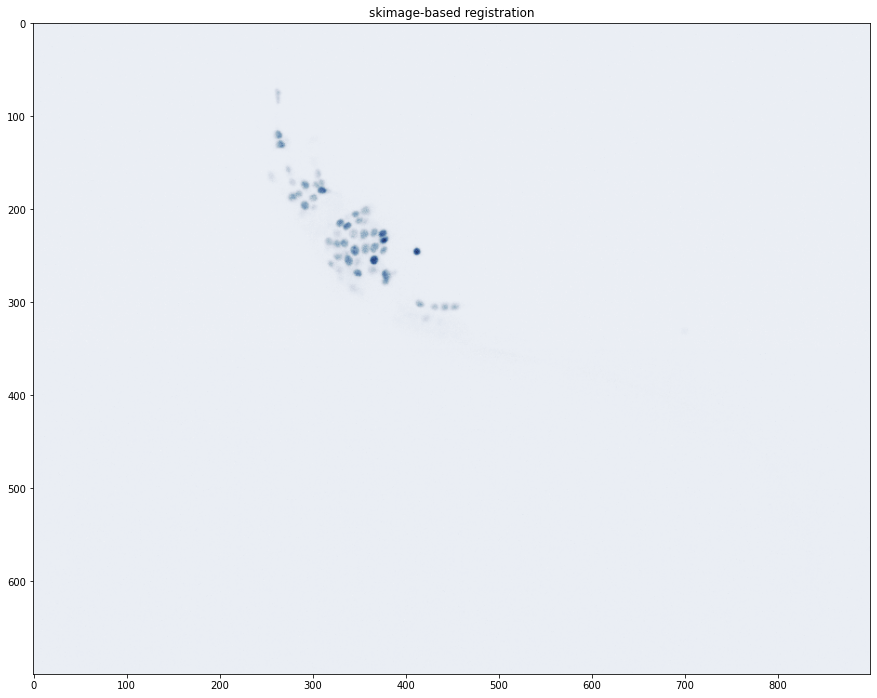

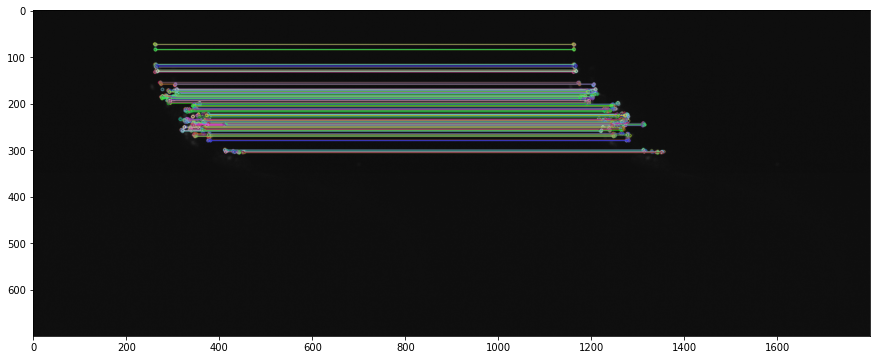

In [44]:
# Now do skimage
im1Reg_skimage, h, keypoints1, keypoints2, matches = alignImages(im1, im2)

fig, axis = plt.subplots(figsize=(15, 15))
axis.imshow(im2, cmap='Reds', alpha=0.8)
axis.imshow(im1Reg_skimage, cmap='Blues', alpha=0.8)
plt.title("skimage-based registration")

imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
fig, axis = plt.subplots(figsize=(15, 15))

plt.imshow(imMatches)

# Align a video

In [176]:
def align_video(all_fnames, which_slice=15, num_frames=10, ref_frame=0, use_skimage=True):
    
    to_uint8 = lambda f : ((f-np.min(f))/np.max(f)*255.0).astype('uint8')
    filt = lambda img : to_uint8(cv2.bilateralFilter(img.astype('float32'), d=9, sigmaColor=50, sigmaSpace=3)) 

    # Get reference frame
    full_fname = os.path.join(folder_name,all_fnames[ref_frame])
    im_reference = filt(tifffile.imread(full_fname)[which_slice,...])

    registered_frames = []
    # Read other frames and register them
    for i in range(num_frames):
        if i==ref_frame:
            continue
        print(f'Analyzing frame {i} / {num_frames-1}')
        
        full_fname = os.path.join(folder_name,all_fnames[i])
        im1 = filt(tifffile.imread(full_fname)[which_slice,...])
    
        imReg, _,_,_,_ = alignImages(im1, im_reference, use_skimage)
        
        registered_frames.append(imReg)
    
    print("Finished Analyzing")
    
    return registered_frames, im_reference


In [180]:
folder_name = '/groups/zimmer/Ulises/wbfm/wbfm_december2018/20181220/data/worm1/mCherry/ome/'
all_fnames = os.listdir(folder_name)
all_fnames = sorted(all_fnames)[1:]

reg_frames, im_reference = align_video(all_fnames, use_skimage=True)

Analyzing frame 1 / 9
Analyzing frame 2 / 9
Analyzing frame 3 / 9
Analyzing frame 4 / 9
Analyzing frame 5 / 9
Analyzing frame 6 / 9
Analyzing frame 7 / 9
Analyzing frame 8 / 9
Analyzing frame 9 / 9
Finished Analyzing


In [181]:
def interactive_plotter(reg_frames, im_reference, i=0):
    fig, axis = plt.subplots(figsize=(15, 15))
    axis.imshow(im_reference, cmap='Reds', alpha=0.8)
    axis.imshow(reg_frames[i], cmap='Blues', alpha=0.8)
    plt.title(f"Reference frame {i}")
    plt.show()
from ipywidgets import interact, interactive, fixed, interact_manual


In [182]:
f = lambda i : interactive_plotter(reg_frames, im_reference, i)
interact(f, i=(0,len(reg_frames)-1))

interactive(children=(IntSlider(value=4, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [ ]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit